## Explaining a linear regression model

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models. One of the simplest model types is standard linear regression, and so below we train a linear regression model on the classic boston housing dataset. This dataset consists of 506 neighboorhood regions around Boston in 1978, where our goal is to predict the median home price (in thousands) in each neighboorhood from 14 different features:

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000’s

In [2]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

### Examining the model coefficients
The most common way of understanding a linear model is to examine the coefficients learned for each feature. These coefficients tell us how much the model output changes when we change each of the input features:

In [3]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


While coefficients are great for telling us what will happen when we change the value of an input feature, by themselves, they are not a great way to measure the overall importance of a feature. This is because the value of each coefficient depends on the scale of the input features. If for example we were to measure the age of a home in minutes instead of years, then the coefficients for the AGE feature would become 0.0007∗365∗24∗60=367.92. Clearly the number of minutes since a house was built is not more important than the number of years, yet its coefficient value is much larger. This means that the magnitude of a coefficient is not necessarily a good measure of a feature’s importance in a linear model.

### A more complete picture using partial dependence plots
To understand a feature’s importance in a model it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values. To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

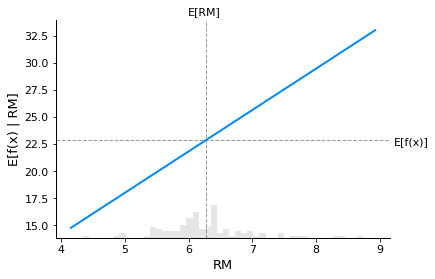

In [15]:
shap.plots.partial_dependence(
    "RM", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

The gray horizontal line in the plot above represents the expected value of the model when applied to the boston housing dataset. The vertical gray line represents the average value of the AGE feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the AGE feature to a given value) always passes through the interesection of the two gray expected value lines. We can consider this intersection point as the “center” of the partial dependence plot with respect to the data distribution. The impact of this centering will become clear when we turn to Shapley values next.

### Reading SHAP values from partial dependence plots
SHAP values can be very complicated to compute (they are NP-hard in general), but linear models are so simple that we can read the SHAP values right off a partial dependence plot. When we are explaining a prediction f(x), the SHAP value for a specific feature i is just the difference between the expected model output and the partial dependence plot at the feature’s value x*i*:

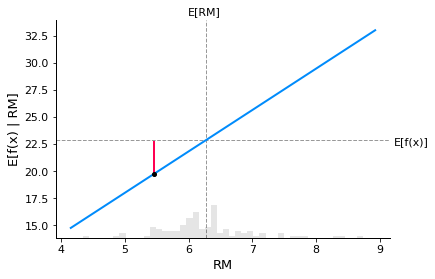

In [19]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "RM", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

The close correspondence between the classic partial dependence plot and SHAP values means that if we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature:

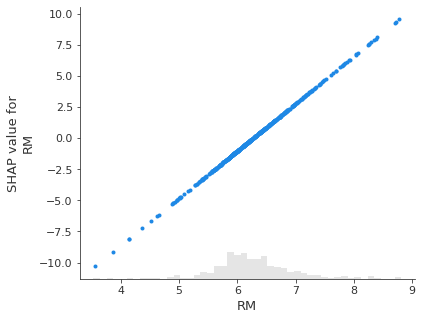

In [17]:
shap.plots.scatter(shap_values[:,"RM"])

### The additive nature of Shapley values
One the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. The easiest way to see this is through a waterfall plot that starts our background prior expectation for a home price E[f(X)], and then adds features one at a time until we reach the current model output f(x):

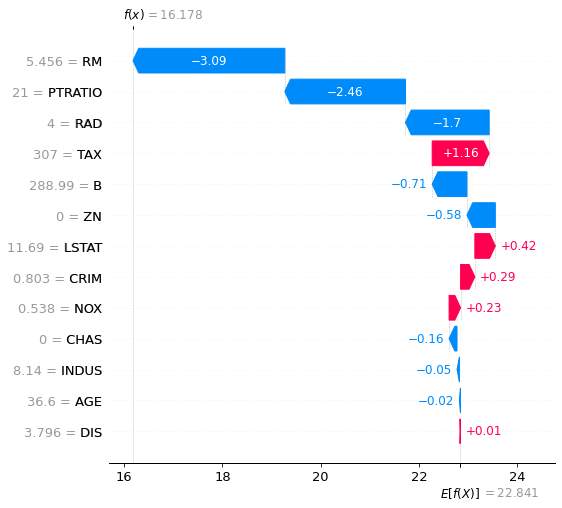

In [20]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

## Explaining an additive regression model

The reason the partial dependence plots of linear models have such a close connection to SHAP values is because each feature in the model is handled independently of every other feature (the effects are just added together). We can keep this additive nature while relaxing the linear requirement of straight lines. This results in the well-known class of generalized additive models (GAMs). While there are many ways to train these types of models (like setting an XGBoost model to depth-1), we will use InterpretMLs explainable boosting machines that are specifically designed for this.

In [4]:
# fit a GAM model to the data
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

Permutation explainer: 507it [00:43, 10.10it/s]                                                                        


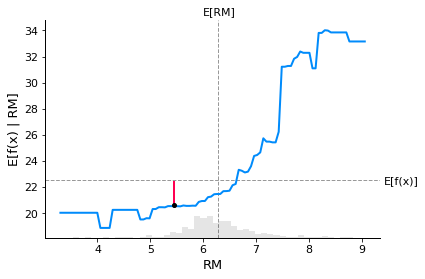

In [6]:
# make a standard partial dependence plot with a single SHAP value overlaid

sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "RM", model_ebm.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

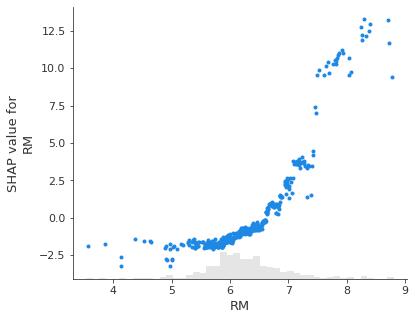

In [7]:
shap.plots.scatter(shap_values_ebm[:,"RM"])

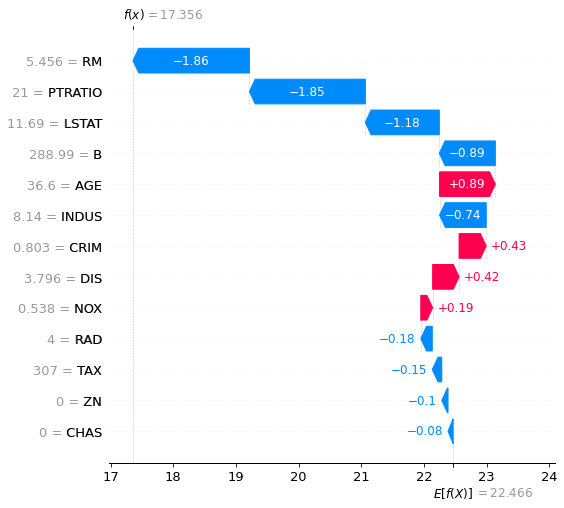

In [8]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind], max_display=14)

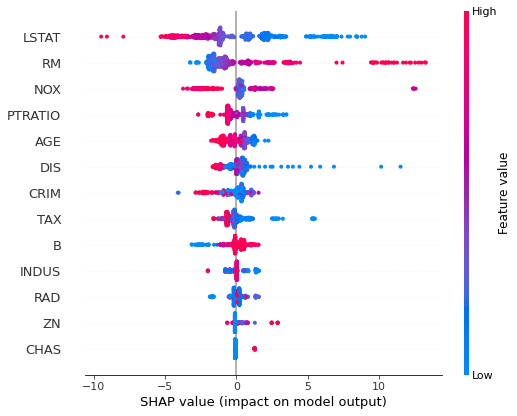

In [5]:
shap.plots.beeswarm(shap_values_ebm, max_display=14)

## Explaining a non-additive boosted tree model

In [12]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

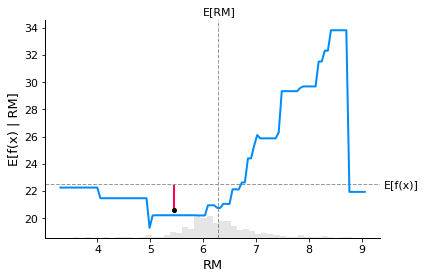

In [13]:
# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_xgb.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

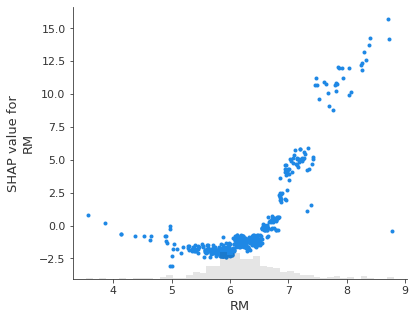

In [14]:
shap.plots.scatter(shap_values_xgb[:,"RM"])

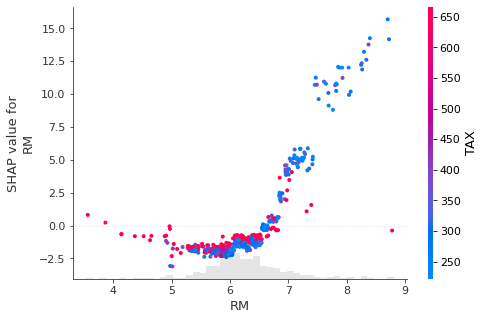

In [16]:
shap.plots.scatter(shap_values_xgb[:,"RM"], color=shap_values_xgb)

## Explaining a linear logistic regression model

In [17]:
# a classic adult census dataset price dataset
X_adult,y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]

Note that explaining the probability of a linear logistic regression model is not linear in the inputs.

In [18]:
X_adult.keys()

Index(['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country'],
      dtype='object')

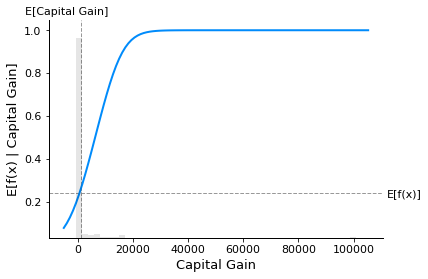

In [36]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

If we use SHAP to explain the probability of a linear logistic regression model we see strong interaction effects. This is because a linear logistic regression model NOT additive in the probability space.

In [21]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

Permutation explainer: 1001it [00:29, 22.62it/s]                                                                       


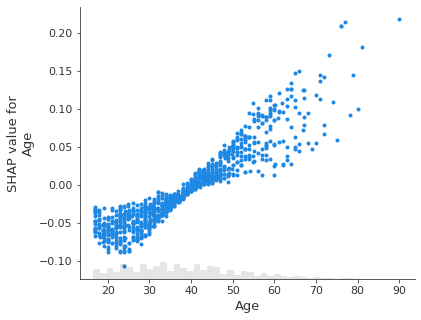

In [55]:
shap.plots.scatter(shap_values_adult[:,"Age"])

If we instead explain the log-odds output of the model we see a perfect linear relationship between the models inputs and the model’s outputs. It is important to remember what the units are of the model you are explaining, and that explaining different model outputs can lead to very different views of the model’s behavior.

In [58]:
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

Permutation explainer: 1001it [00:30, 21.59it/s]                                                                       


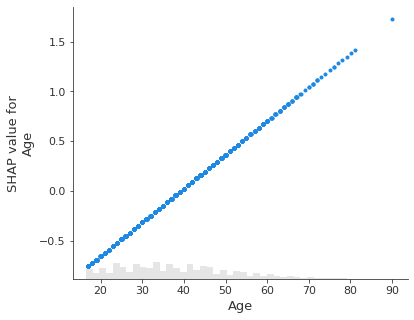

In [59]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Age"])

divide by zero encountered in log


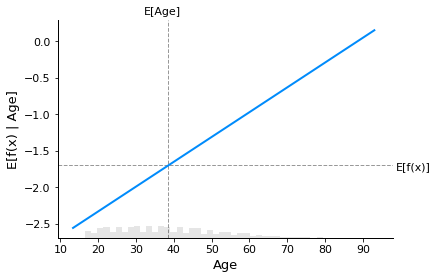

In [60]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Age", model_adult_log_odds, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

## Explaining a non-additive boosted tree logistic regression model

In [61]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 96%|=================== | 31239/32561 [00:26<00:01]       

In [72]:
shap_values.display_data

array([[39.0, ' State-gov', 13.0, ..., 0.0, 40.0, ' United-States'],
       [50.0, ' Self-emp-not-inc', 13.0, ..., 0.0, 13.0,
        ' United-States'],
       [38.0, ' Private', 9.0, ..., 0.0, 40.0, ' United-States'],
       ...,
       [58.0, ' Private', 9.0, ..., 0.0, 40.0, ' United-States'],
       [22.0, ' Private', 9.0, ..., 0.0, 20.0, ' United-States'],
       [52.0, ' Self-emp-inc', 9.0, ..., 0.0, 40.0, ' United-States']],
      dtype=object)

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

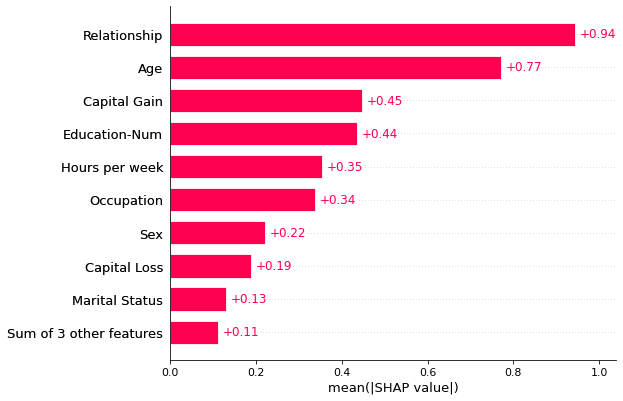

In [69]:
shap.plots.bar(shap_values)

But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrequent but high magnitude effects.



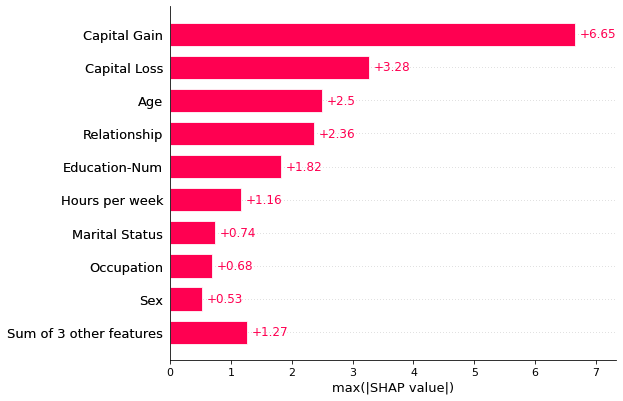

In [70]:
shap.plots.bar(shap_values.abs.max(0))

If we are willing to deal with a bit more complexity we can use a beeswarm plot to summarize the entire distribution of SHAP values for each feature.

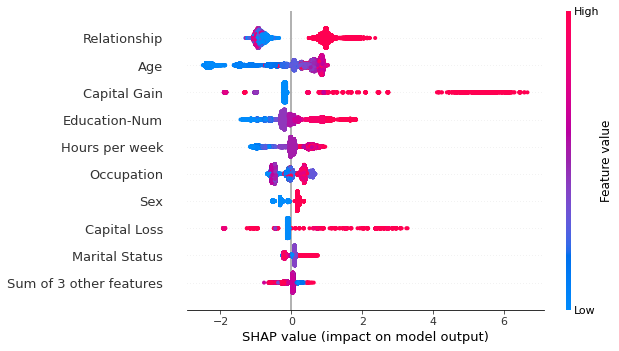

In [71]:
shap.plots.beeswarm(shap_values)

By taking the absolute value and using a solid color we get a compromise between the complexity of the bar plot and the full beeswarm plot. Note that the bar plots above are just summary statistics from the values shown in the beeswarm plots below.

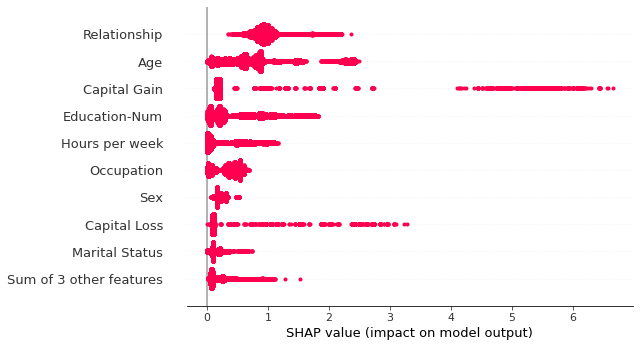

In [76]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

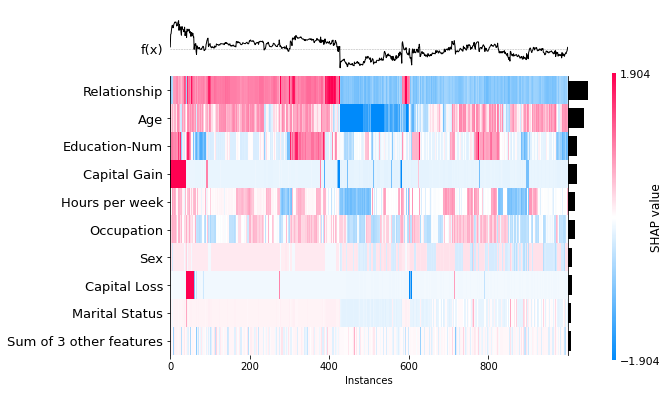

In [77]:
shap.plots.heatmap(shap_values[:1000])

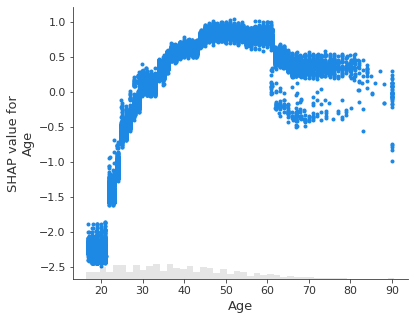

In [78]:
shap.plots.scatter(shap_values[:,"Age"])

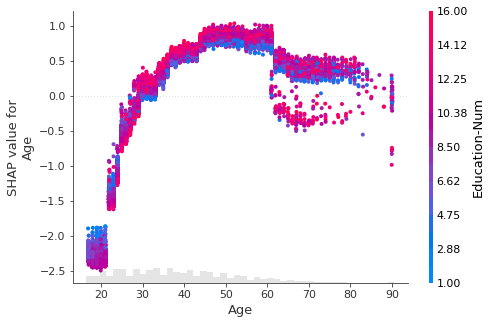

In [79]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values)

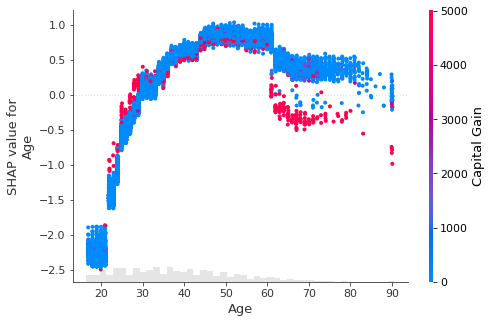

In [85]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"Capital Gain"])

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


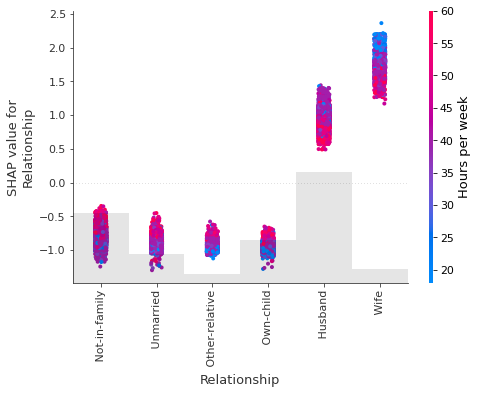

In [86]:
shap.plots.scatter(shap_values[:,"Relationship"], color=shap_values)

## Dealing with correlated features

In [87]:
clustering = shap.utils.hclust(X_adult, y_adult)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


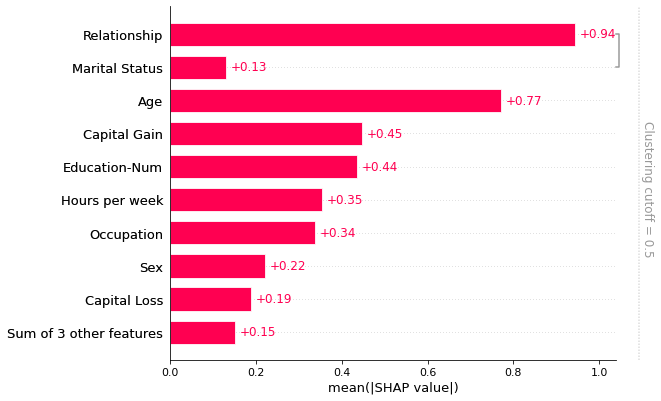

In [89]:
shap.plots.bar(shap_values, clustering=clustering)

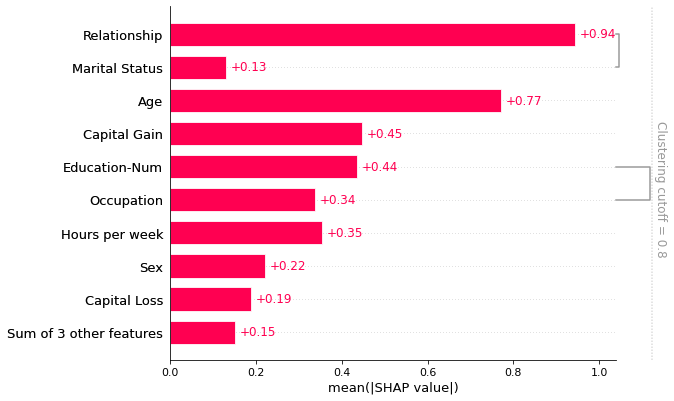

In [90]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

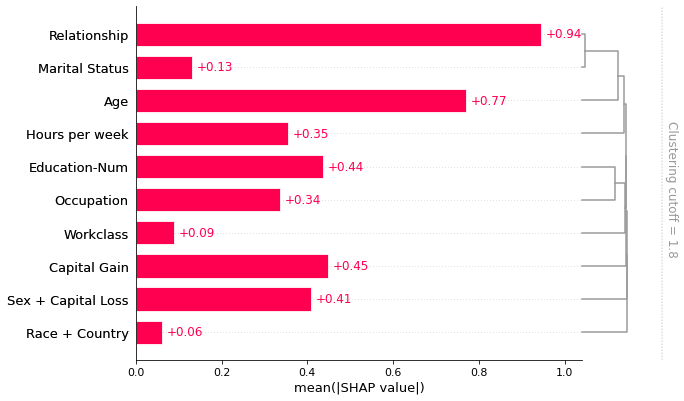

In [95]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

## Explaining a transformers NLP model

In [1]:
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

In [2]:
# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1)

In [ ]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])